Link model sebelumnya

```
https://colab.research.google.com/drive/1UWv-PaQIid8oQonBsAEbsvDus1I2yB3V?usp=sharing
```



In [ ]:
import datetime
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout

**Downloading Data**

In [ ]:
!gdown --id 1p2IE1otdkUWs8_ucIm03QWNp4EbiWcQK

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1p2IE1otdkUWs8_ucIm03QWNp4EbiWcQK
To: /content/CLASS.zip
100% 2.53G/2.53G [00:22<00:00, 112MB/s]


In [ ]:
!unzip CLASS.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/4_9.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_11.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_12.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_17.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_18.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_2.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_21.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5_4.jpg  
  inflating: CLASS/7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001/5

**Cropping**

In [ ]:
parent_folder_path = "/content/CLASS"

In [ ]:
for subfolder_name in os.listdir(parent_folder_path):
  subfolder_path = os.path.join(parent_folder_path, subfolder_name)
  for image_name in os.listdir(subfolder_path):
    image_path = os.path.join(subfolder_path, image_name)
    if os.path.isfile(image_path):
            im = Image.open(image_path)
            f, e = os.path.splitext(image_path)
            width, height = im.size   # Get dimensions
            left = (width - 228)/2
            top = (height - 228)/2
            right = (width + 228)/2
            bottom = (height + 228)/2

            im = im.crop((left, top, right, bottom))
            im.save(f + '.jpg')

In [ ]:
im = Image.open('/content/CLASS/8. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k-20231208T013253Z-001/0_11.jpg')
print(im.size)

(228, 228)


**Creating Labels**

In [ ]:
# create empty lists to store the image paths and their corresponding class labels
image_paths = []
class_labels = []

# create an empty dictionary to store the class label to subfolder name mappings
class_label_map = {}

# loop through each subfolder in the parent folder
for subfolder_name in os.listdir(parent_folder_path):
    # get the starting number of the subfolder name
    class_label = int(subfolder_name.split(".")[0]) - 1

    # add the class label and subfolder name to the dictionary
    class_label_map[class_label] = subfolder_name.split(".")[1].split(" ")[1]

    # loop through each image file in the subfolder
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    for image_name in os.listdir(subfolder_path):
        # get the full path to the image file
        image_path = os.path.join(subfolder_path, image_name)
        # append the image path and class label to the lists
        image_paths.append(image_path)
        class_labels.append(class_label)

# create a pandas DataFrame from the image paths and class labels
data = {"image_path": image_paths, "class_label": class_labels}
df = pd.DataFrame(data)

# print the class label map
class_label_map

{4: 'Benign',
 2: 'Basal',
 8: 'Warts',
 6: 'Seborrheic',
 5: 'Psoriasis',
 1: 'Melanoma',
 7: 'Tinea',
 3: 'Melanocytic',
 0: 'Eczema'}

In [ ]:
df

,image_path,class_label
0,/content/CLASS/5. Benign Keratosis-like Lesion...,4
1,/content/CLASS/5. Benign Keratosis-like Lesion...,4
2,/content/CLASS/5. Benign Keratosis-like Lesion...,4
3,/content/CLASS/5. Benign Keratosis-like Lesion...,4
4,/content/CLASS/5. Benign Keratosis-like Lesion...,4
...,...,...
15295,/content/CLASS/1. Eczema/t-eczema-face-6.jpg,0
15296,/content/CLASS/1. Eczema/3_9.jpg,0
15297,/content/CLASS/1. Eczema/2_10.jpg,0
15298,/content/CLASS/1. Eczema/t-eczema-fingertips-8...,0


In [ ]:
# Get the list of subdirectories in the dataset directory (each subdirectory corresponds to a class)
class_names = os.listdir(parent_folder_path)

# Loop over the subdirectories and count the number of files in each one
for class_name in class_names:
    class_dir = os.path.join(parent_folder_path, class_name)
    num_images = len(os.listdir(class_dir))
    print("Class {}: {} images".format(class_name, num_images))

Class 8. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k-20231208T013253Z-001: 1700 images
Class 4. Melanocytic Nevi (NV) - 7970-20231208T005235Z-001: 1700 images
Class 6. Psoriasis pictures Lichen Planus and related diseases - 2k-20231208T012142Z-001: 1700 images
Class 7. Seborrheic Keratoses and other Benign Tumors - 1.8k-20231208T012711Z-001: 1700 images
Class 2. Melanoma: 1700 images
Class 3. Basal Cell Carcinoma (BCC) 3323-20231206T185147Z-001: 1700 images
Class 1. Eczema: 1700 images
Class 9. Warts Molluscum and other Viral Infections - 2103-20231208T014208Z-001: 1700 images
Class 5. Benign Keratosis-like Lesions (BKL) 2624-20231208T011452Z-001: 1700 images


**Preprocessing**

In [ ]:
import concurrent.futures

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

8

In [ ]:
# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((227,227)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays
df

,image_path,class_label,image
0,/content/CLASS/5. Benign Keratosis-like Lesion...,4,"[[[182, 156, 169], [183, 157, 170], [184, 158,..."
1,/content/CLASS/5. Benign Keratosis-like Lesion...,4,"[[[182, 146, 114], [179, 143, 111], [178, 142,..."
2,/content/CLASS/5. Benign Keratosis-like Lesion...,4,"[[[216, 136, 139], [216, 136, 139], [215, 135,..."
3,/content/CLASS/5. Benign Keratosis-like Lesion...,4,"[[[57, 41, 41], [56, 40, 40], [54, 38, 38], [5..."
4,/content/CLASS/5. Benign Keratosis-like Lesion...,4,"[[[212, 191, 210], [212, 191, 210], [212, 190,..."
...,...,...,...
15295,/content/CLASS/1. Eczema/t-eczema-face-6.jpg,0,"[[[191, 143, 139], [181, 133, 129], [183, 135,..."
15296,/content/CLASS/1. Eczema/3_9.jpg,0,"[[[3, 0, 0], [10, 6, 3], [10, 6, 3], [3, 0, 0]..."
15297,/content/CLASS/1. Eczema/2_10.jpg,0,"[[[0, 3, 5], [0, 3, 4], [0, 2, 4], [0, 5, 2], ..."
15298,/content/CLASS/1. Eczema/t-eczema-fingertips-8...,0,"[[[169, 127, 105], [173, 131, 109], [177, 135,..."


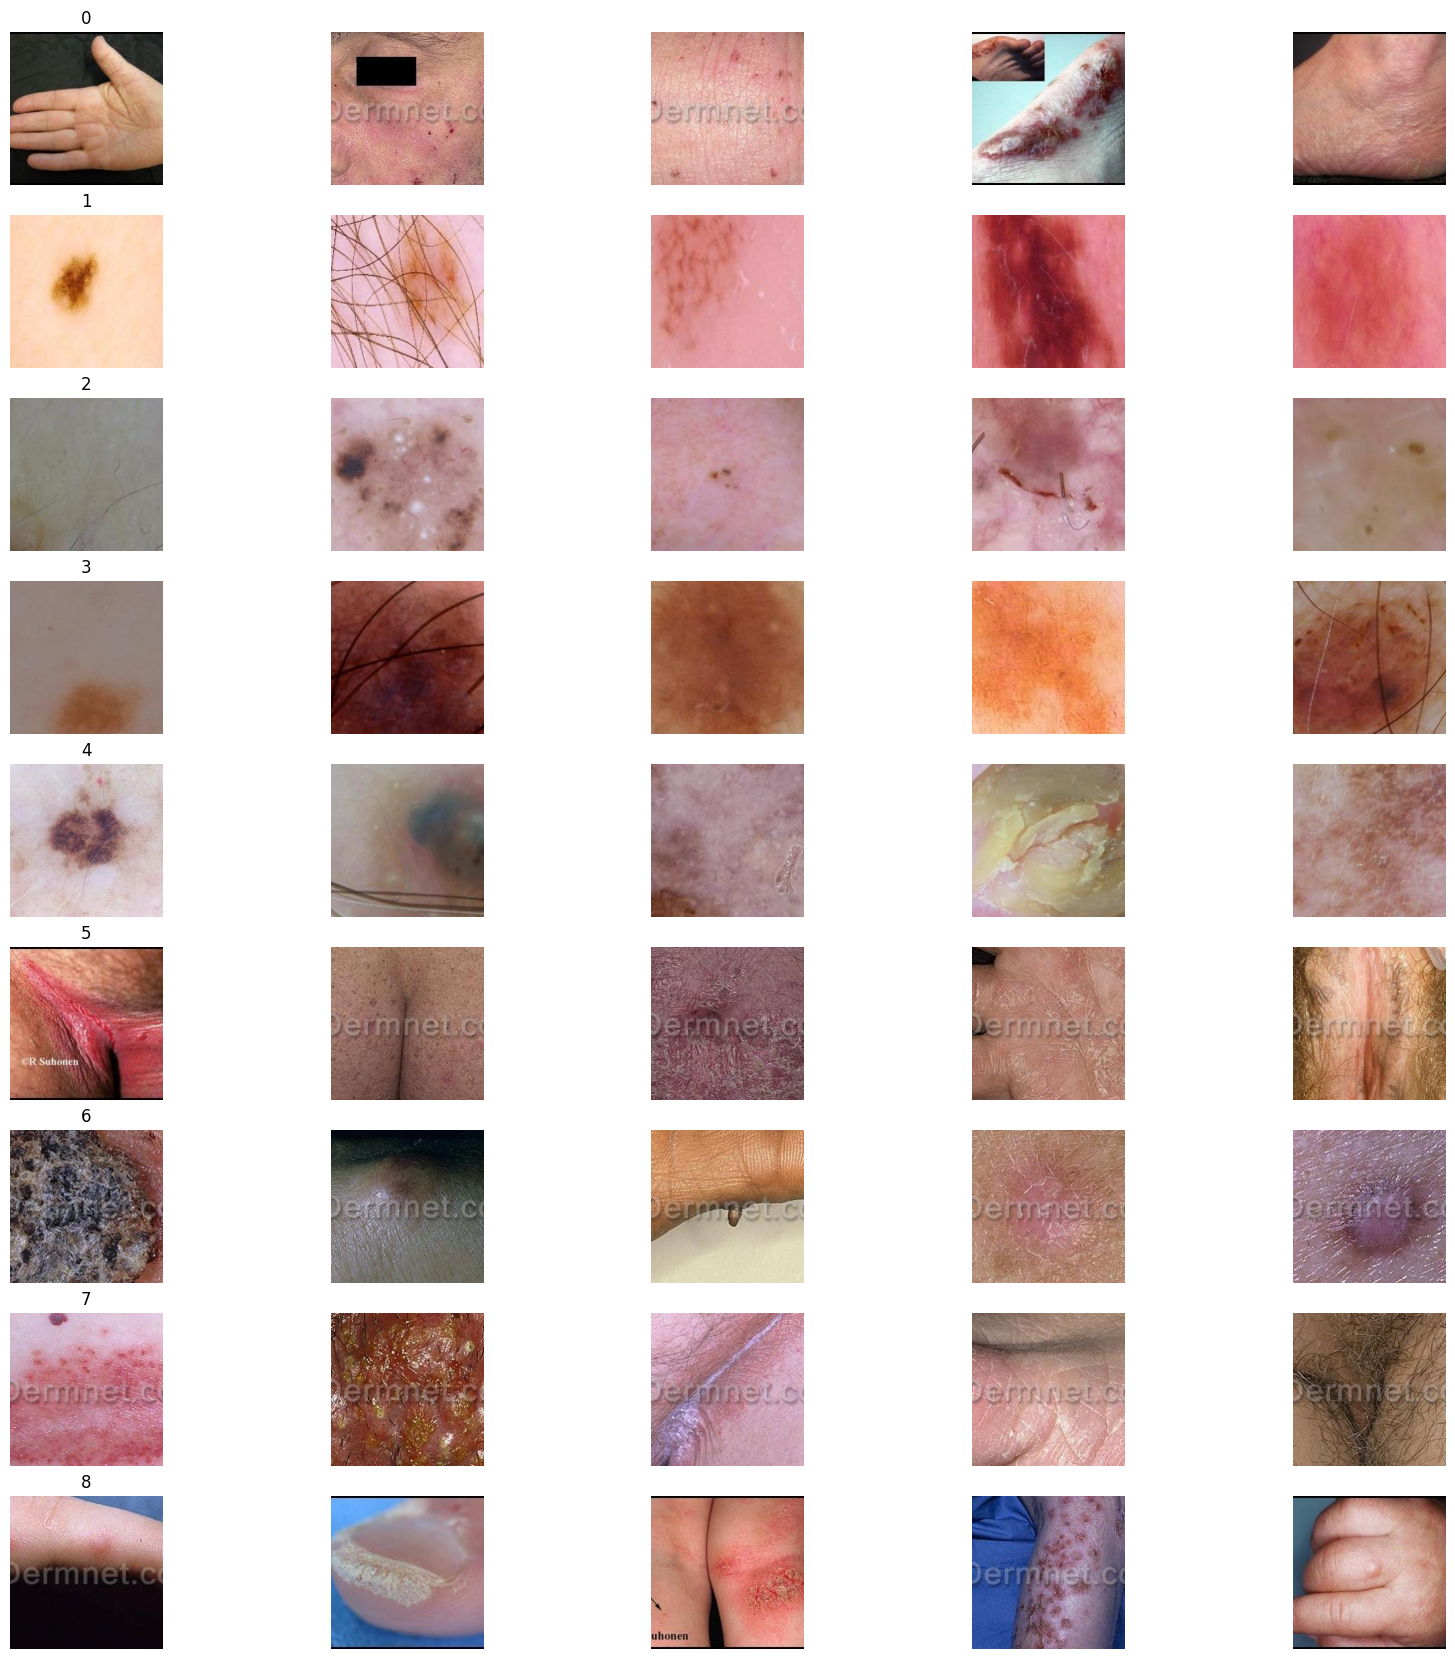

In [ ]:
n_samples = 5
fig, m_axs = plt.subplots(9, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['class_label']).groupby('class_label')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
df['image'].map(lambda x: x.shape).value_counts()

(227, 227, 3)    15300
Name: image, dtype: int64

**data augmentation**

In [ ]:
# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
max_images_per_class = 1700

In [ ]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'class_label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['class_label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['class_label'] == class_label, 'image'].values

    # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)

    # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

        # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)

            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'class_label': class_label, 'image': augmented_image_array}, ignore_index=True)

    # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['class_label'] == class_label, ['image_path', 'class_label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('class_label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


<ipython-input-15-73b0d96616c7>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-15-73b0d96616c7>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-15-73b0d96616c7>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-15-73b0d96616c7>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append(original_images_df, ignore_index=True)
<ipython-input-15-73

In [ ]:
df.groupby('class_label').size()

class_label
0    1700
1    1700
2    1700
3    1700
4    1700
5    1700
6    1700
7    1700
8    1700
dtype: int64

In [ ]:
# Count the number of images in each class
class_counts = df['class_label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 50)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 50)
for class_label, class_name in class_label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 50)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
--------------------------------------------------
Class Label     Class Name                     Count     
--------------------------------------------------
1               Melanoma                       1700      
7               Tinea                          1700      
4               Benign                         1700      
2               Basal                          1700      
3               Melanocytic                    1700      
6               Seborrheic                     1700      
0               Eczema                         1700      
5               Psoriasis                      1700      
8               Warts                          1700      
--------------------------------------------------
Total                                         15300     


**Split Dataset**

In [ ]:
features=df.drop(columns=['class_label','image_path'],axis=1)
target=df['class_label']

In [ ]:
target.head()

0    7
1    7
2    8
3    8
4    3
Name: class_label, dtype: object

In [ ]:
print(target.shape,features.shape)

(15300,) (15300, 1)


In [ ]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [ ]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [ ]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o,num_classes = 9)
y_test = to_categorical(y_test_o,num_classes = 9)
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [ ]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(227, 227, 3))
x_test = x_test.reshape(x_test.shape[0], *(227, 227, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(227, 227, 3))

**Modeling**

In [ ]:
num_classes = 9
input_shape = (227, 227, 3)

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 227, 227, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 227, 227, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 113, 113, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 113, 113, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 113, 113, 32)      9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 113, 113, 32)      9248      
                                                        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss="categorical_crossentropy", metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

**Training**

In [ ]:
# Set a learning rate annealer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [ ]:
# training parameters
EPOCHS = 100
BATCH_SIZE = 32
image_height = 227
image_width = 227

In [ ]:
import time
start = time.time()

history = model.fit(x=x_train,
                    y=y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_validate,y_validate))

print("Total time: ", time.time() - start, "seconds")

Epoch 1/100
345/345 [==============================] - 63s 153ms/step - loss: 1.8195 - accuracy: 0.2897 - precision: 0.5772 - recall: 0.0693 - val_loss: 1.5994 - val_accuracy: 0.3660 - val_precision: 0.5923 - val_recall: 0.0629
Epoch 2/100
345/345 [==============================] - 50s 144ms/step - loss: 1.4563 - accuracy: 0.3985 - precision: 0.6122 - recall: 0.1711 - val_loss: 1.3919 - val_accuracy: 0.4273 - val_precision: 0.7249 - val_recall: 0.1356
Epoch 3/100
345/345 [==============================] - 50s 145ms/step - loss: 1.3592 - accuracy: 0.4225 - precision: 0.6271 - recall: 0.2031 - val_loss: 1.3460 - val_accuracy: 0.4420 - val_precision: 0.7068 - val_recall: 0.1438
Epoch 4/100
345/345 [==============================] - 50s 145ms/step - loss: 1.3013 - accuracy: 0.4470 - precision: 0.6548 - recall: 0.2290 - val_loss: 1.3264 - val_accuracy: 0.4461 - val_precision: 0.6410 - val_recall: 0.1969
Epoch 5/100
345/345 [==============================] - 50s 146ms/step - loss: 1.2544 - a

In [ ]:
print("Accuracy of the model is - " , model.evaluate(x_validate,y_validate)[1]*100 , "%")

39/39 [==============================] - 1s 27ms/step - loss: 4.4164 - accuracy: 0.4967 - precision: 0.4971 - recall: 0.4877
Accuracy of the model is -  49.67320263385773 %


**Evaluation**

In [ ]:
predictions = model.predict(x_test)
import numpy as np
print(np.argmax(y_test[:20], axis=1))
print(np.argmax(predictions[:20], axis=1))

96/96 [==============================] - 3s 33ms/step
[0 0 4 0 3 7 5 6 4 8 1 5 3 7 6 3 0 7 2 3]
[7 6 4 5 3 7 5 6 2 6 1 7 3 5 0 3 0 7 2 3]


In [ ]:
# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

96/96 [==============================] - 2s 23ms/step


<Axes: >

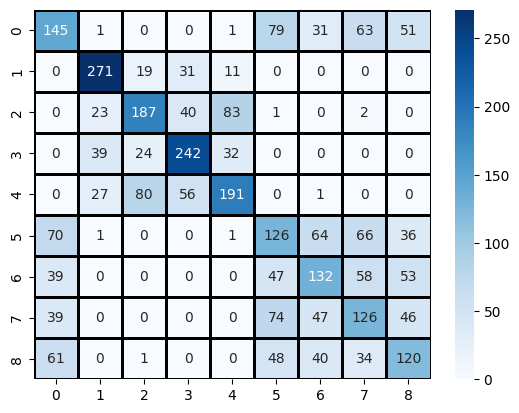

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred_prob, axis=1))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5033
Precision: 0.5025
Recall: 0.5046


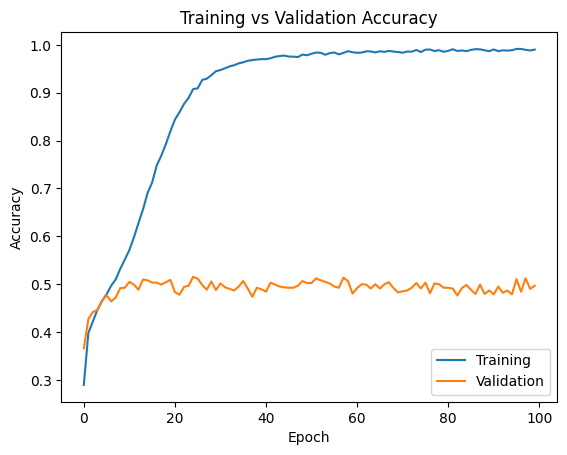

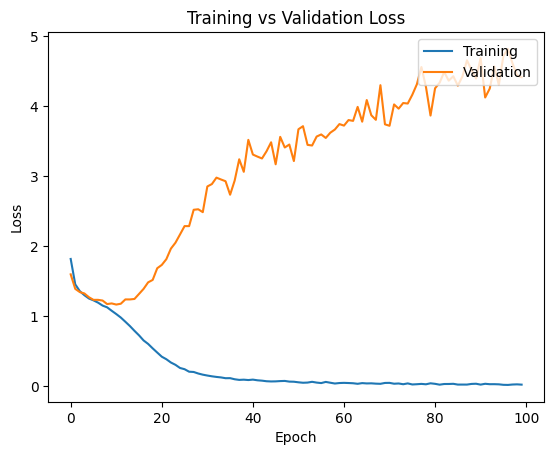

In [ ]:
import matplotlib.pyplot as plt

# Get training and testing accuracy and loss histories
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and testing accuracy curves
plt.plot(training_accuracy)
plt.plot(validation_accuracy)
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

# Plot training and testing loss curves
plt.plot(training_loss)
plt.plot(validation_loss)
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:

print(confusion_matrix(y_test,y_pred))
print("")
print(accuracy_score(y_test, y_pred))

In [ ]:
model.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
saved_model_path = "/content/gdrive/MyDrive/model2.h5"

model.save(saved_model_path)